6DOF Inverse Kinematics using IKPY
==================================

This is a demo of how to use IKPY to move a 6DOF robot arm.

Please don't comment and tell me how rubbish this code is, it's meant to demonstrate how easy this is to use, not to show off mad Python skills.

We'll start by importing all our libraries

In [3]:
import ikpy.chain
import ikpy.utils.plot as plot_utils

import numpy as np
import time
import math
import ipywidgets as widgets
# import serial

Now, we can import our robot arm model from the URDF file. The first link is the link between the desk and the base, so we set it to inactive

In [4]:
my_chain = ikpy.chain.Chain.from_urdf_file("arm_urdf.urdf",active_links_mask=[False, True, True, True, True, True])

And set the initial position and orientation of the last joint

It's now just one call to work out the inverse kinematics for that position. Again, the first angle is of the inactive joint between the desk and the base so is always 0

In [5]:
target_position = [ 0.3048, 0.3048,0.1]

target_orientation = np.eye(3)
target_orientation[:,0]=np.array([1, 0, 0])
target_orientation[:,1]=np.array([0, -1, 0])
target_orientation[:,2]=np.array([0, 0, -1])

ik = my_chain.inverse_kinematics(target_position, target_orientation, orientation_mode="all")
print("The degrees of each joints are : ", list(map(lambda r:math.degrees(r),ik.tolist())))
print("The radians of each joints are : ", list(map(lambda r:r,ik.tolist())))

The degrees of each joints are :  [0.0, 31.585715899347377, -29.854525172350918, -58.680547218191855, -91.46492760942465, 31.58571589934731]
The radians of each joints are :  [0.0, 0.5512747390431336, -0.5210597608770511, -1.0241687558294472, -1.5963641368827262, 0.5512747390431324]


We can see that actual position our robot will move to. This may be different to _target_position_ as the arm may not be physically able to reach that position

In [6]:
computed_position = my_chain.forward_kinematics(ik)
print("Computed position: %s, original position : %s" % (computed_position[:3, 3], target_position))
print("Computed position (readable) : %s" % [ '%.2f' % elem for elem in computed_position[:3, 3] ])

Computed position: [0.3048 0.3048 0.1   ], original position : [0.3048, 0.3048, 0.1]
Computed position (readable) : ['0.30', '0.30', '0.10']


Now, lets visualise what our arm looks

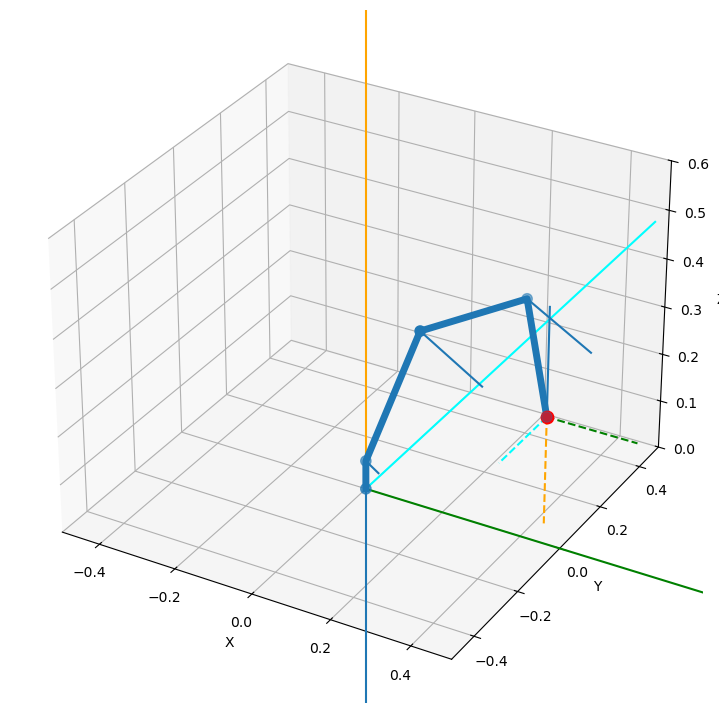

In [7]:
#%matplotlib widget
import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
fig.set_figheight(9)  
fig.set_figwidth(13)  
my_chain.plot(ik, ax, target=target_position)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.set_zlim(0, 0.6)
plt.ion()

Let's now make wrap up some of these calls into a couple of functions. Calling _move(x,y,z)_ will move us to the new coordinates and update the plot.

It's worth noting here that when we call _inverse_kinematcs_, we pass in the old position (joint angles) as _initial_position_ so IKPY find the nearest solution to our current position.

In [6]:
def doIK():
    global ik
    old_position= ik.copy()
    ik = my_chain.inverse_kinematics(target_position, target_orientation, orientation_mode="all", initial_position=old_position)

def updatePlot():
    fig, ax = plot_utils.init_3d_figure()
    fig.set_figheight(9)  
    fig.set_figwidth(13)  
    my_chain.plot(ik, ax, target=target_position)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    ax.set_zlim(0, 0.6)
    plt.ion()
    
    
    
def move(x,y,z):
    global target_position
    target_position = [x,y,z]
    doIK()
    updatePlot()

    # sendCommand(ik[1].item(),ik[2].item(),ik[3].item(),ik[4].item(),ik[5].item(),ik[6].item(),1)

We should now be able to move our visualised arm with a call to _move(x,y,z)_

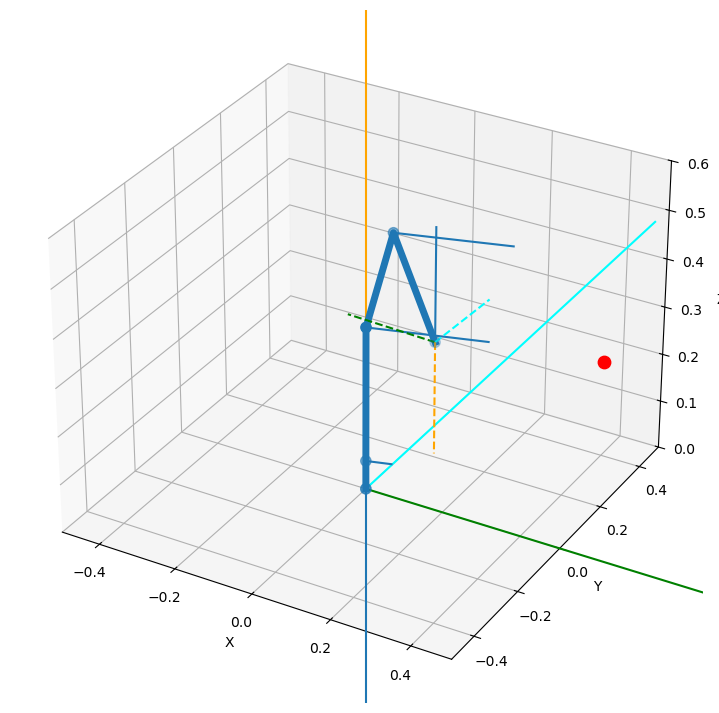

In [25]:
target_orientation = np.eye(3)
target_orientation[:,0]=np.array([-1, 0, 0])
target_orientation[:,1]=np.array([0, 1, 0])
target_orientation[:,2]=np.array([0, 0, -1])
move(0.4,0.4,0.2)

Let's now connect to our robot arm and create a function to send the angles to it. We just have to uncomment that _sendcommand_ line in the move function to make this work

In [5]:
from pynput import keyboard
key_x = 0
key_y = 0
key_z = 0
step_size=0.02
def on_key_release(key):
    global key_x, key_y, key_z
    try:
        if key.char == 'q':
            return False
        elif key.char == 'a':
            key_x -= step_size
        elif key.char == 'd':
            key_x += step_size
        elif key.char == 'w':
            key_y += step_size
        elif key.char == 's':
            key_y -= step_size
        elif key.char == 'r':
            key_z += step_size
        elif key.char == 'f':
            key_z -= step_size
            # if key_z < 0:
            #     key_z = 0
    except AttributeError:
        if key == keyboard.Key.up:
            key_z += step_size
        elif key == keyboard.Key.down:
            key_z -= step_size
            if key_z < 0:
                key_z = 0
                
    # print(key_x, key_y, key_z)
    
    
### Blockingq
# with keyboard.Listener(on_release=on_key_release) as listener:
#     listener.join()

### Non-blocking
# listener = keyboard.Listener(on_release=on_key_release)
# listener.start()
# listener.stop() ## call to end

The degrees of each joints are :  [0.0, -1.542556266247706e-09, -4.536944281509026e-09, -4.811910640132228e-09, -3.2393680840688025e-09, 5.729577951308233e-09]
The radians of each joints are :  [0.0, -2.6922685743292745e-11, -7.918461569186099e-11, -8.398368398205537e-11, -5.653763875102107e-11, 1e-10]
Computed position: [1.00000000e-01 1.16689332e-10 8.30000000e-01], original position : [0.3048, 0.3048, 0.04]
Computed position (readable) : ['0.10', '0.00', '0.83']


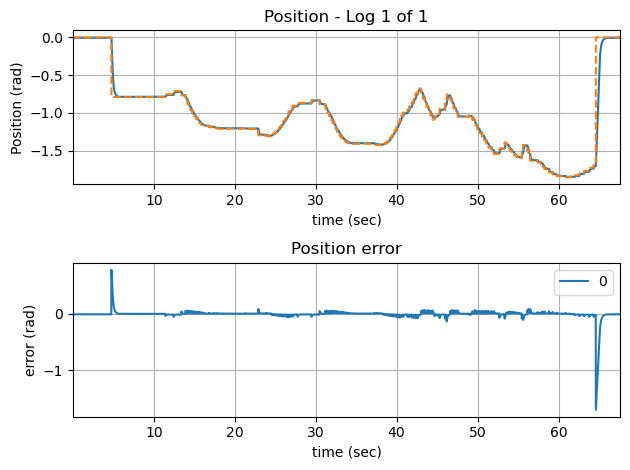

In [6]:
import hebi
from pynput import keyboard
from math import pi, sin

lookup = hebi.Lookup()

# Wait 2 seconds for the module list to populate
time.sleep(1.0)

family_name = "fourGrowers"
module_name = "Wrist" #Elbow, Shoulder, Base

base = lookup.get_group_from_names([family_name], ["Base"])
shoulder = lookup.get_group_from_names([family_name], ["Shoulder"])
elbow = lookup.get_group_from_names([family_name], ["Elbow"])
wrist = lookup.get_group_from_names([family_name], ["Wrist"])

if base is None or shoulder is None or elbow is None or wrist is None:
    print('Group not found: Did you forget to set the module family and name above?')
    exit(1)

base_command = hebi.GroupCommand(base.size)
base_feedback = hebi.GroupFeedback(base.size)
shoulder_command = hebi.GroupCommand(shoulder.size)
shoulder_feedback = hebi.GroupFeedback(shoulder.size)
elbow_command = hebi.GroupCommand(elbow.size)
elbow_feedback = hebi.GroupFeedback(elbow.size)
wrist_command = hebi.GroupCommand(wrist.size)
wrist_feedback = hebi.GroupFeedback(wrist.size)

# Start logging in the background
base.start_log('logs', mkdirs=True)
shoulder.start_log('logs', mkdirs=True)
elbow.start_log('logs', mkdirs=True)
wrist.start_log('logs', mkdirs=True)


# First give robot time to go straight up
duration = 1.5              # [sec]
start = time.time()
t = time.time() - start

while t < duration:
    # Even though we don't use the feedback, getting feedback conveniently
    # limits the loop rate to the feedback frequency
    wrist.get_next_feedback(reuse_fbk=wrist_feedback)
    t = time.time() - start

    base_command.position = 1.57
    base.send_command(base_command)
    shoulder_command.position = 1.57
    shoulder.send_command(shoulder_command)
    elbow_command.position = 0
    elbow.send_command(elbow_command)
    wrist_command.position = 0
    wrist.send_command(wrist_command)


# Then move to desired starting position
initial_position = [0.3048, 0.3048,0.04]

target_orientation = np.eye(3)
target_orientation[:,0]=np.array([1, 0, 0])
target_orientation[:,1]=np.array([0, -1, 0])
target_orientation[:,2]=np.array([0, 0, -1])

ik = my_chain.inverse_kinematics(initial_position)
print("The degrees of each joints are : ", list(map(lambda r:math.degrees(r),ik.tolist())))
print("The radians of each joints are : ", list(map(lambda r:r,ik.tolist())))
jointAngles = ik.tolist()
ikBasePos = jointAngles[1]
ikShoulderPos = jointAngles[2]
ikElbowPos = jointAngles[3]
ikWristPos = jointAngles[4]

computed_position = my_chain.forward_kinematics(ik)
computed_coords = computed_position[:3, 3]
# prev_coords = computed_coords.copy()
print("Computed position: %s, original position : %s" % (computed_position[:3, 3], initial_position))
print("Computed position (readable) : %s" % [ '%.2f' % elem for elem in computed_position[:3, 3] ])

duration = 3              # [sec]
start = time.time()
t = time.time() - start

# Don't go through floor no matter what
if computed_position[:3, 3][2] > 0.02:
    while t < duration:
        # Even though we don't use the feedback, getting feedback conveniently
        # limits the loop rate to the feedback frequency
        wrist.get_next_feedback(reuse_fbk=wrist_feedback)
        t = time.time() - start

        base_command.position = ikBasePos+1.57
        base.send_command(base_command)
        shoulder_command.position = ikShoulderPos+1.57
        shoulder.send_command(shoulder_command)
        elbow_command.position = -ikElbowPos
        elbow.send_command(elbow_command)
        wrist_command.position = ikWristPos
        wrist.send_command(wrist_command)

# Then move around a bit from there
# setup keyboard listener to control movements
key_x = 0
key_y = 0
key_z = 0

listener = keyboard.Listener(on_release=on_key_release)
listener.start()

duration = 60              # [sec]
start = time.time()
t = time.time() - start

while t < duration:
    # Even though we don't use the feedback, getting feedback conveniently
    # limits the loop rate to the feedback frequency
    wrist.get_next_feedback(reuse_fbk=wrist_feedback)
    t = time.time() - start


    # Get jointAngles from IK
    target_position = np.array(initial_position)
    # target_position[2] = initial_position[2] + sin(3*t)*0.1 # move in a sine wave on up down
    target_position[0] = initial_position[0] + key_x
    target_position[1] = initial_position[1] + key_y
    target_position[2] = initial_position[2] + key_z

    target_orientation = np.eye(3)
    target_orientation[:,0]=np.array([1, 0, 0])
    target_orientation[:,1]=np.array([0, 1, 0])
    target_orientation[:,2]=np.array([0, 0, 1])
    
    old_position= ik.copy()
    ik = my_chain.inverse_kinematics(target_position, initial_position=old_position)
    jointAngles = ik.tolist()
    ikBasePos = jointAngles[1]
    ikShoulderPos = jointAngles[2]
    ikElbowPos = jointAngles[3]
    ikWristPos = jointAngles[4]

    computed_position = my_chain.forward_kinematics(ik)

    # Dont let robot go through the floor no matter what
    # And make sure things aren't flailing around when jumping between solutions
    if computed_position[:3, 3][2] > 0.02:# and np.linalg.norm(computed_coords-prev_coords) < 0.2:
        base_command.position = -ikBasePos+1.57
        base.send_command(base_command)
        shoulder_command.position = ikShoulderPos+1.57
        shoulder.send_command(shoulder_command)
        elbow_command.position = -ikElbowPos
        elbow.send_command(elbow_command)
        wrist_command.position = ikWristPos
        wrist.send_command(wrist_command)

# Stop keyboard listener
listener.stop()

# Then end back in straight up, so things dont slouch when they lose power
duration = 3              # [sec]
start = time.time()
t = time.time() - start

while t < duration:
    # Even though we don't use the feedback, getting feedback conveniently
    # limits the loop rate to the feedback frequency
    wrist.get_next_feedback(reuse_fbk=wrist_feedback)
    t = time.time() - start

    base_command.position = 1.57
    base.send_command(base_command)
    shoulder_command.position = 1.57
    shoulder.send_command(shoulder_command)
    elbow_command.position = 0
    elbow.send_command(elbow_command)
    wrist_command.position = 0
    wrist.send_command(wrist_command)

# group.command_lifetime=1000.0
# group_command.position = 0
# group.send_command(group_command)
# group_command.position = 3.14
# group.send_command(group_command)


# for i in range(0, 100):
#     print(i/10)
#     group_command.position = i/10
#     group.send_command(group_command)
#     time.sleep(0.3)


# Stop logging. `log_file` contains the contents of the file
log_file = wrist.stop_log()

if log_file is not None:
    hebi.util.plot_logs(log_file, 'position')
if False:
    print("HUH")
    # put typing stuff here lol:wswwwdadddraaaaaaassssrrrrrrrrrrrrddssssssssssssssssswawwwwwwwwwwwwwwwwwdasssssssssssssssssswwwwwwwwwwwwwwwwwwddddddaaaaaaawwwwwwsssssrrrrsssaaaaawwaaaaaaaaawwsssrrrrrrrrrrrrrrrrrwdddaaaaaaaaaaaaaawwwrrrrrrrrrrrrrrrrrrrrrrrrrrrrrsssssssssssrrrsrsrsrsrsrsrssrrrrrrrrrrrrrrrrrrrrrrrrrrrrrraaaaaaaaaaaaaaaaaaaasssssssssssssssssssdwrrrrrrrrrrrrrrrrrrrrrrrrrrrrssssssddddddaaaaaaaaaaaaaaaaaaarrrrrrrrwwwwwwaaaarddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwwwwwddddddddaafffff
    